In [180]:
import pickle
import numpy as np
import json
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import pandas as pd

In [413]:
LEVEL_NAMES = ["section", "class", "subclass", "main group", "subgroup"]

In [78]:
# helper functions
def read_pickle(filepath):
    with open(filepath,"rb") as f:
        output = pickle.load(f)
    return output

def get_row_count(file_path):
    count = 0
    with open(file_path, 'r') as f:
        for line in f:
            count += 1
    return count

def list_to_dict(cur_list):
    cur_dict = dict()
    for i, label in enumerate(cur_list):
        cur_dict[label] = i
    return cur_dict

In [419]:
# NOT USED

# given the path of the true labels and the label to id map
# return a numpy array of size (# of instance, # of labels)
# where each row is an n-hot vector indicating true label(s)
def get_truth_arrays(truth_path, label_to_id_map):
    
    # number of levels
    num_level = len(list(label_to_id_map.keys())[0].split("--"))
    
    # dimension of truth array: (num of levels, num of instances, num of labels)
    truth_array = np.zeros((num_level, get_row_count(truth_path), len(label_to_id_map)), dtype = int)
    
    # loop over all the rows in the truth file
    with open(truth_path, 'r') as truth_file:  
        for i, truth in enumerate(truth_file):
            true_labels = json.loads(truth)["doc_label"]
            true_sub_labels_sets = [set() for _ in range(num_level - 1)]
            
            for true_label in true_labels:
                
                # the lowest level
                truth_array[-1][i][label_to_id_map[true_label]] = 1
                
                # save true labels for the other levels
                true_sub_labels = true_label.split("--")[:-1]
                for j, true_sub_label in enumerate(true_sub_labels):
                    true_sub_labels_sets[j].add(true_sub_label)
            
            # loop over all possible labels and see if they are partially correct
            for label in label_to_id_map.keys():
                sub_labels = label.split("--")[:-1]
                for k, sub_label in enumerate(sub_labels):
                    if sub_label in true_sub_labels_sets[k]:
                        truth_array[k][i][label_to_id_map[label]] = 1
                  
    return truth_array

In [420]:
# return a numpy array of size (# of instance, # of labels)
# where each row is an n-hot vector indicating true label(s)
def get_truth_array(truth_path, label_to_id_map):
    
    truth_array = np.zeros((get_row_count(truth_path), len(label_to_id_map)), dtype = int)
    
    with open(truth_path, 'r') as truth_file:  
        for i, truth in enumerate(truth_file):
            true_labels = json.loads(truth)["doc_label"]
            for true_label in true_labels:
                true_id = label_to_id_map[true_label]
                truth_array[i][true_id] = 1
    return truth_array

In [385]:
def single_to_multi_level_array(truth_array, probs, label_to_id_map):
    
    # number of levels
    num_level = len(list(label_to_id_map.keys())[0].split("--"))
    
    low_to_high_maps = [dict() for _ in range(num_level - 1)]

    for label, label_id in label_to_id_map.items():
        
        sub_labels = label.split("--")[:-1]
        for i, sub_label in enumerate(sub_labels):
            if sub_label not in low_to_high_maps[i]:
                low_to_high_maps[i][sub_label] = [label_id]
            else:
                low_to_high_maps[i][sub_label].append(label_id)
    
    truth_arrays = [np.zeros((len(probs), len(low_to_high_map))) for low_to_high_map in low_to_high_maps]
    probs_arrays = [np.zeros((len(probs), len(low_to_high_map))) for low_to_high_map in low_to_high_maps]

    for i, low_to_high_map in enumerate(low_to_high_maps):
        for j, (high_label, low_ids) in enumerate(low_to_high_map.items()):
            truth_arrays[i][:, j] = truth_array[:, low_ids].sum(axis = 1).clip(0, 1)
            probs_arrays[i][:, j] = probs[:, low_ids].sum(axis = 1)
    
    return truth_arrays, probs_arrays

In [80]:
# used for 3rd model (tencent)
def get_predicted_probs_from_json(probs_path):
    probs = []
    with open(probs_path, 'r') as probs_file:  
        for prob in probs_file:
            probs.append(json.loads(prob))
    return np.array(probs)

In [282]:
def convert_at_to_dash(at_string):
    labels = at_string.split("@")
    prefix = ""
    long_labels = []
    for label in labels:
        long_label = prefix + label
        long_labels.append(long_label)
        prefix = long_label
    return "--".join(long_labels)

In [288]:
# used for 2nd model (HFT-CNN)
def get_predicted_probs_from_json_with_header(probs_path):
    probs = []
    with open(probs_path, 'r') as probs_file:  
        for i, prob in enumerate(probs_file):
            if i == 0:
                label_list = prob.rstrip().split(",")
                if "@" in label_list[0]:
                    label_list = [convert_at_to_dash(at_string) for at_string in label_list]
            else:
                json_string = "[{}]".format(prob.rstrip())
                probs.append(json.loads(json_string))
    return list_to_dict(label_list), np.array(probs)

In [243]:
def prob_to_rank(probs):
    label_count = probs.shape[1]
    ranks = pd.DataFrame(probs).rank(axis=1, method='max')
    return np.array(ranks)

In [405]:
def get_auc(precisions, recalls):
    auc = 0
    for i in range(len(precisions) - 1):
        auc += (precisions[i] + precisions[i+1]) * (recalls[i] - recalls[i+1]) / 2
    return auc

In [426]:
# generate pr curve
def get_pr_curve(truth_array, probs, title_prefix):
    
    prob_precisions, prob_recalls, prob_thresholds = precision_recall_curve(truth_array.ravel(), probs.ravel())
    prob_auc = get_auc(prob_precisions, prob_recalls)
    
    ranks = prob_to_rank(probs)
    rank_precisions, rank_recalls, rank_thresholds = precision_recall_curve(truth_array.ravel(), ranks.ravel())
    rank_auc = get_auc(rank_precisions, rank_recalls)
    
    plt.figure()
    plt.step(prob_recalls, prob_precisions, where='post', label='prob')
    plt.step(rank_recalls, rank_precisions, where='post', label='rank')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc='upper right')
    plt.title('{0}, AUC: prob {1:0.2f} rank {2:0.2f}'
              .format(title_prefix, prob_auc, rank_auc))
    
    prob_result = prob_precisions, prob_recalls, prob_thresholds, prob_auc
    rank_result = rank_precisions, rank_recalls, rank_thresholds, rank_auc
    plt.show()
    return prob_result, rank_result

In [471]:
# generate pr curve
def get_pr_curves(truth_path, label_to_id_map, probs):
    
    prob_results, rank_results = [], []
    
    truth_array = get_truth_array(truth_path, label_to_id_map)
    
    higher_truth_arrays, higher_probs_arrays = single_to_multi_level_array(truth_array, probs, label_to_id_map)
    
    for i in range(len(higher_truth_arrays)):
        prob_result, rank_result = get_pr_curve(higher_truth_arrays[i], higher_probs_arrays[i], LEVEL_NAMES[i])
        prob_results.append(prob_result)
        rank_results.append(rank_result)
    
    prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")
    prob_results.append(prob_result)
    rank_results.append(rank_result)
    
    higher_truth_arrays.append(truth_array)
    higher_probs_arrays.append(probs)
   
    prob_result, rank_result = get_pr_curve(np.concatenate(higher_truth_arrays, axis = 1), 
                                            np.concatenate(higher_probs_arrays, axis = 1), "subclass adjusted")
    prob_results.append(prob_result)
    rank_results.append(rank_result)
    
    return prob_results, rank_results

In [453]:
def get_level_indices(subclass_label_to_id_map, level):
    indices = []
    new_map = dict()
    counter = 0
    for i, label in enumerate(subclass_label_to_id_map):
        if label.count("--") == level:
            indices.append(i)
            new_map[label] = counter
            counter += 1
    return np.array(indices), new_map

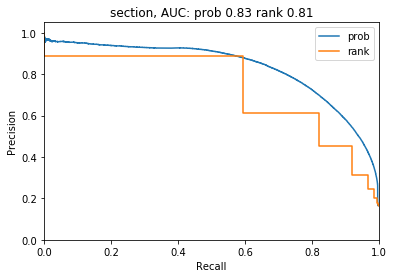

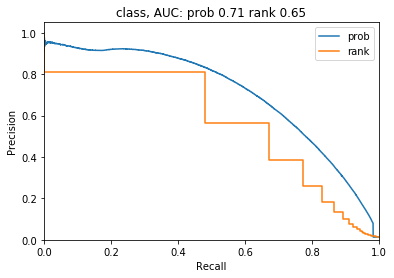

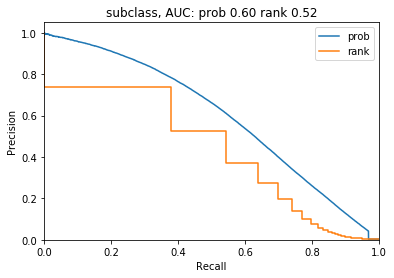

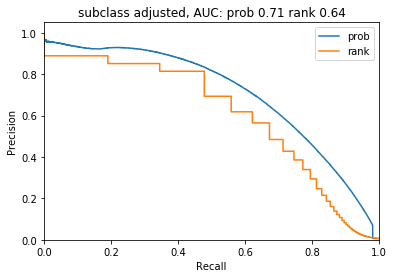

In [472]:
# 2nd model HFT-CNN (summary 150)
probs_path = "../../../../CNN-summary-150.csv"
subclass_label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

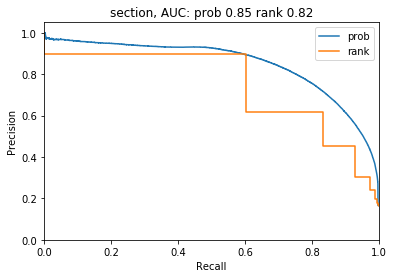

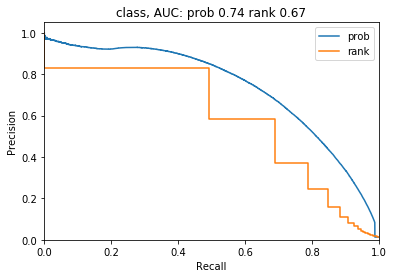

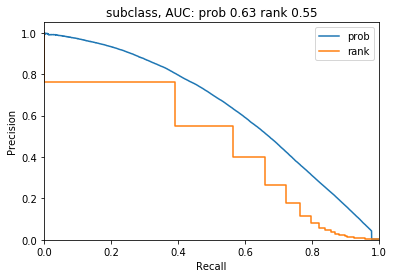

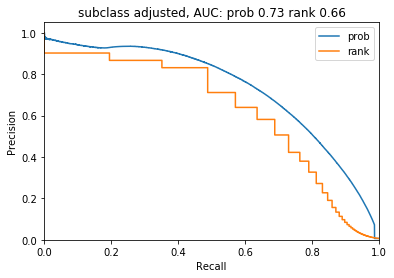

In [473]:
# 2nd model HFT-CNN (summary 1000)
probs_path = "../../../../CNN-summary-1000.csv"
subclass_label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

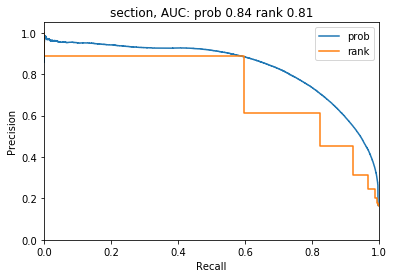

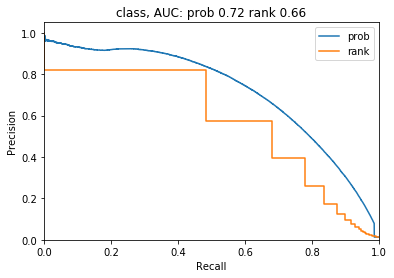

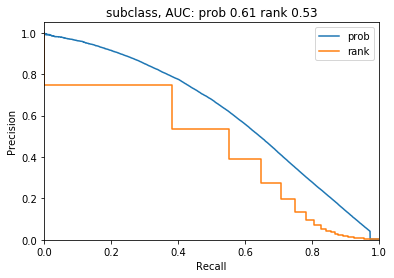

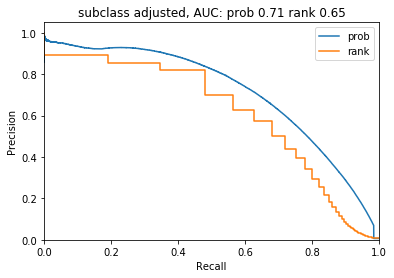

In [474]:
# 2nd model HFT-CNN (description)
probs_path = "../../../../CNN-desc-300.csv"
subclass_label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

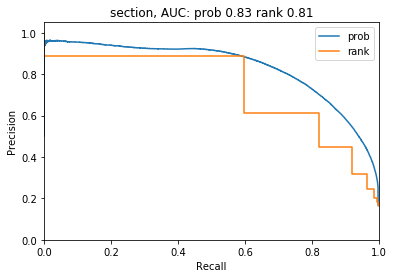

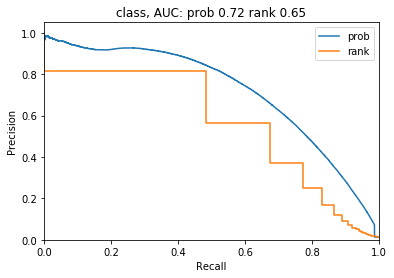

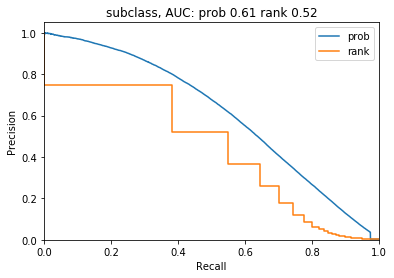

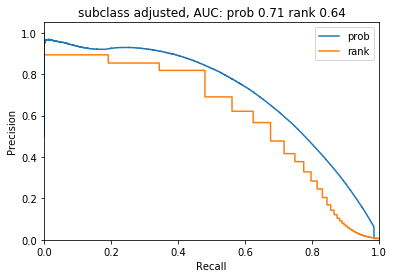

In [475]:
# 2nd model HFT-CNN (title abstract claim)
probs_path = "../../../../probability_3rd.txt"
subclass_label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

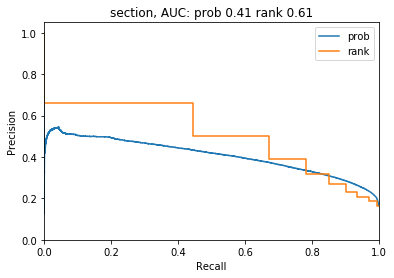

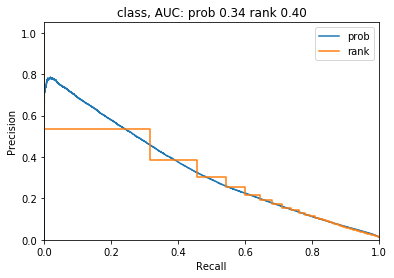

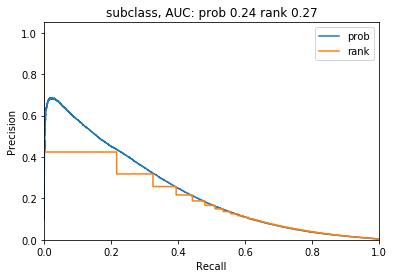

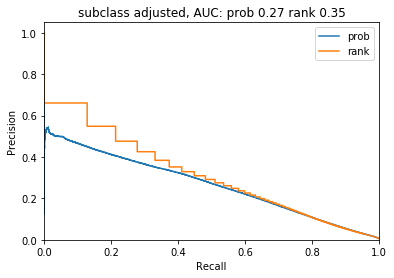

In [482]:
# 3rd model: tencent CNN (title abstract claim)

probs_path = "../../../../probs_pretrain.txt"
label_to_id_maps_path = "../../../../label_to_id_maps_pretrain.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

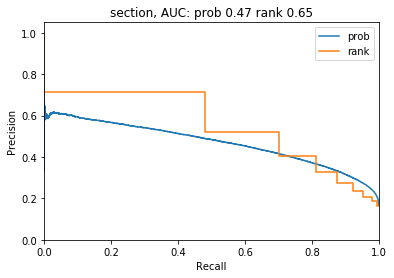

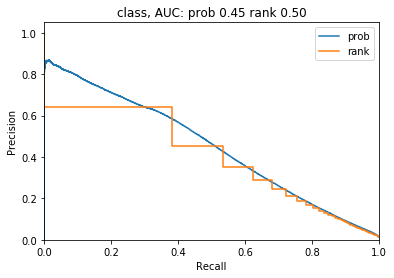

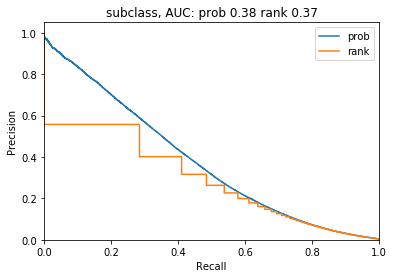

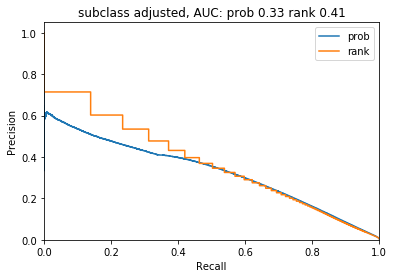

In [476]:
# 3rd model: tencent CNN (title abstract claim)

probs_path = "../../../../probs_claim.txt"
label_to_id_maps_path = "../../../../label_to_id_maps_claim.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

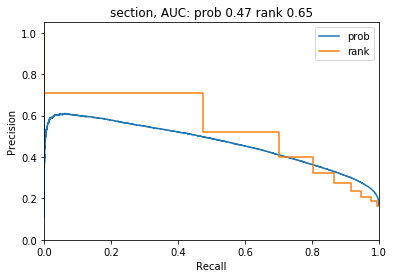

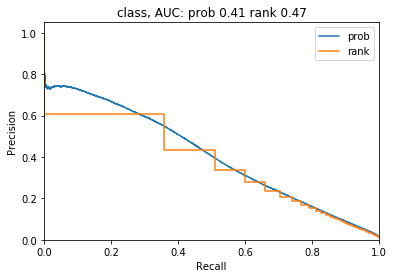

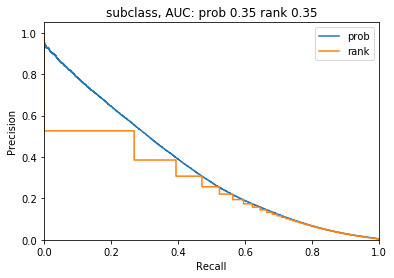

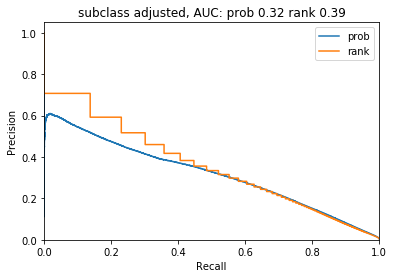

In [477]:
# 3rd model: tencent CNN (summary only)

probs_path = "../../../../probs_sum.txt"
label_to_id_maps_path = "../../../../label_to_id_maps_sum.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

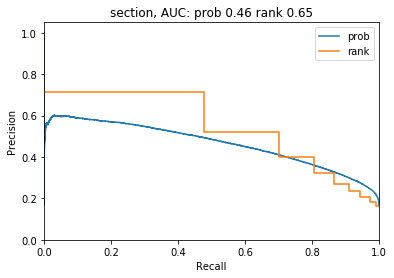

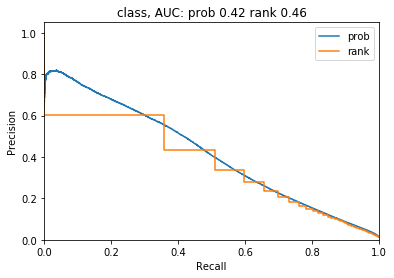

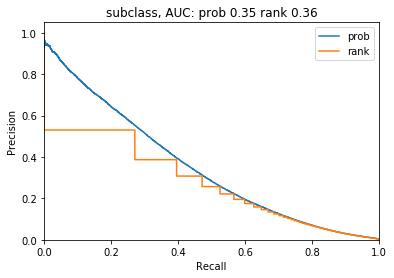

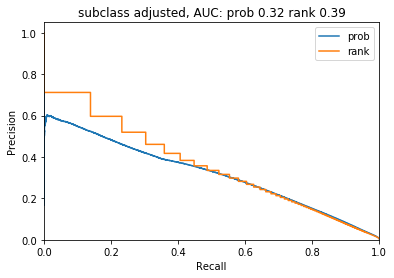

In [478]:
# 3rd model: tencent CNN (desc only)

probs_path = "../../../../probs_desc.txt"
label_to_id_maps_path = "../../../../label_to_id_maps_desc.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

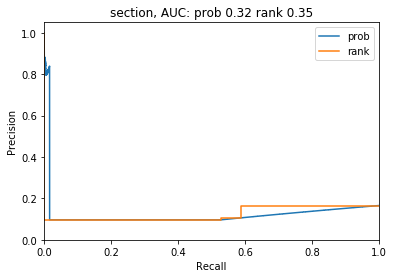

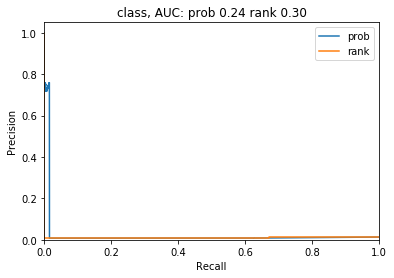

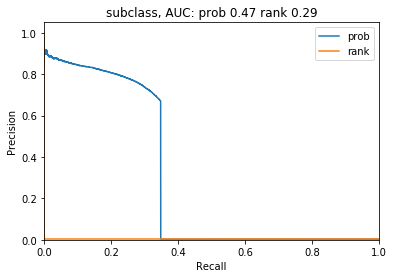

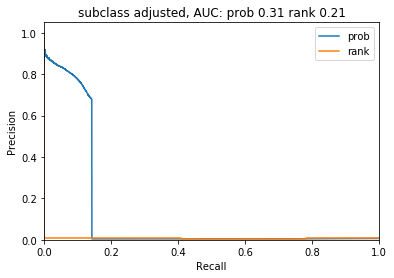

In [479]:
# 1st model: sklearn approach (title abstract claim)

probs_path = "../../../../test_dump_y_pred_parallel_RM"
label_to_id_maps_path = "../../../../mlb_classes"
label_to_id_list = read_pickle(label_to_id_maps_path)
subclass_indices, subclass_label_to_id_map = get_level_indices(list_to_dict(label_to_id_list), 2)
    
probs = np.array(read_pickle(probs_path))[:, subclass_indices]
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

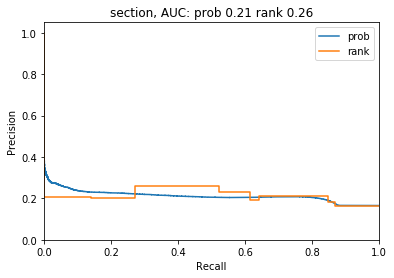

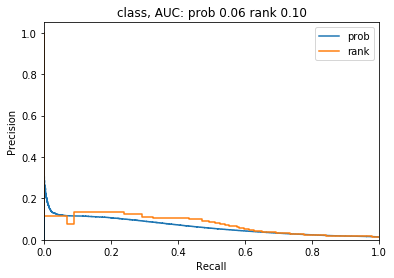

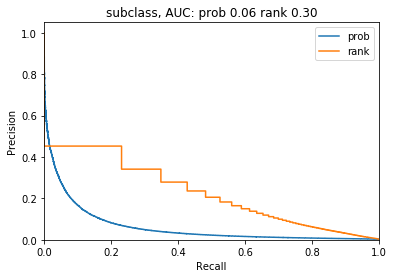

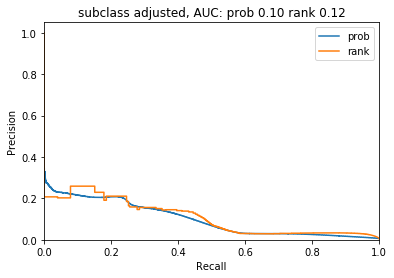

In [480]:
# 4th model: bottom-up approach (title abstract claim)

probs_path = "../../../../result_cos.save"
label_to_id_maps_path = "../../../../node_labels_cos.save"
label_to_id_list = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = list_to_dict(label_to_id_list)
    
probs = np.array(read_pickle(probs_path))
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

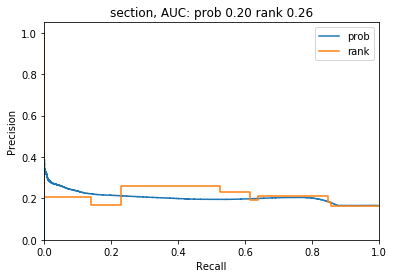

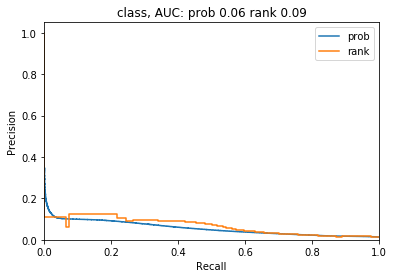

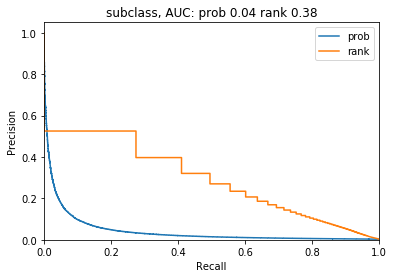

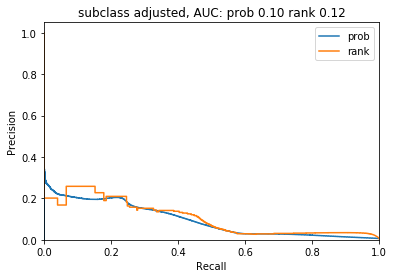

In [481]:
# 4th model: bottom-up approach (summary only)

probs_path = "../../../../result_cos_summary_only"
label_to_id_maps_path = "../../../../node_labels_cos_summary_only"
label_to_id_list = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = dict()
for i, label in enumerate(label_to_id_list):
    subclass_label_to_id_map[label] = i
    
probs = np.array(read_pickle(probs_path))
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)